In [2]:
# In this script I will attempt image recognition to classify pictures into cat-pictures or non-cat-pictures
# This will be done through a custom neural network, this was done during one of my courses on Coursera:
    # http://coursera.org/verify/BXQUF9YE622Y

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [4]:
# Function to recover the Dataset and do it nicely
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

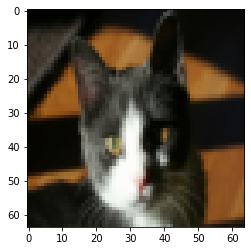

In [15]:
# Example of a picture
index = 19
plt.imshow(train_set_x_orig[index])

In [16]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

In [17]:
# For convenience, we reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px ∗ num_px ∗ 3, 1)

train_set_x_flatten = train_set_x_orig.reshape( train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape( test_set_x_orig.shape[0], -1).T

In [25]:
# standardizing the dataset. To represent colors, the Green, Blue and Red channels must be specified per pixel
    # Therefore the pixel value is actually a vector of 3 numbers ranging from 0 to 255
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The sigmoid function is what we use to translate the score per picture into a label of cat or not-cat

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [27]:
# defining the sigmoid function

def sigmoid(z):
    """
    Arguments:
    z -- A scalar or numpy array of any size.
    """

    s = 1/(1+np.exp(-z))
    return s

In [28]:
# initializing parameters: w and b

def initialize_with_zeros(dim):
    """
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    """

    w = np.zeros((dim, 1))
    b = 0
    return w, b

Forward Propagation:
- Formula $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$


In [29]:
# Forward Propagation and Backward Propagation

def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    """
    
    m = X.shape[1]

    # Forward Propagation
    A = sigmoid(np.dot(w.T, X)+b)                                   # compute activation
    cost = (-1/m)*np.sum((Y*np.log(A))+((1-Y)*np.log(1-A)))         # compute cost

    # Backward Propagation
    dw = (1/m)*np.dot((X), (A-Y).T)
    db = (1/m)*np.sum(A-Y)

    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

Optimization
- Parameters have been initialized
- Time to calculate the cost function and its gradient
- Time to update parameters using gradient descent

In [31]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = True):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)[0], propagate(w, b, X, Y)[1]
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Prediction
1. Calculate Y: $\hat{Y} = A = \sigma(w^T X + b)$

2. Converting the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector

In [33]:
def predict(w, b, X):
    '''
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Computing vector "A": Predicts probability of picture being a cat
    A = sigmoid(np.dot(w.T, X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction = np.where(A > .5, 1, 0)
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

Merge all functions into a model

In [34]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = True):
    """
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the model

We see the following:
- Training accuracy is close to 100%
- Test accuracy is 70%

In [35]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


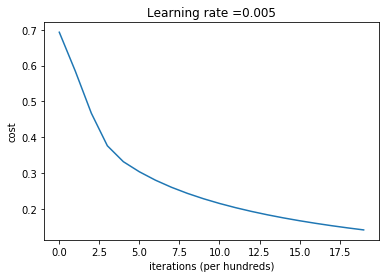

In [36]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Next: Testing some different learning rates

We find:
- Better to stick with the original learning rate of .5

learning rate is: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944
Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591289
Cost after iteration 200: 0.555796
Cost after iteration 300: 0.528977
Cost after iteration 400: 0.506881
Cost after iteration 500: 0.487880
Cost after iteration 600: 0.471108
Cost after iteration 700: 0.456046
Cost after iteration 800: 0.442

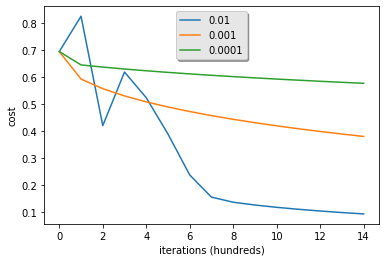

In [38]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()